In [ ]:
# Install all necessary NLP and evaluation libraries
!pip install -U transformers datasets hf_xet sacrebleu evaluate bert-score comet-ml

# BLEURT: clone and install from source (preferred method)
!git clone https://github.com/google-research/bleurt.git
%cd bleurt
!pip install .
%cd ..

!pip install git+https://github.com/Unbabel/COMET

fatal: destination path 'bleurt' already exists and is not an empty directory.
/content/bleurt
Processing /content/bleurt
  Preparing metadata (setup.py) ... done
  Created wheel for BLEURT: filename=BLEURT-0.0.2-py3-none-any.whl size=16456766 sha256=9c1cffd117e30baac96b9081ca32f7aa432fb1896f6c9b8d04342da25e4868f5
  Stored in directory: /tmp/pip-ephem-wheel-cache-c7veozzw/wheels/49/ab/73/9318ab38d4cd1c732bcea8335d3f8d7c0316c8d07b9084fa85
Successfully built BLEURT
  Attempting uninstall: BLEURT
    Found existing installation: BLEURT 0.0.2
    Uninstalling BLEURT-0.0.2:
      Successfully uninstalled BLEURT-0.0.2
/content


In [ ]:
# Project Imports
import os
import json
import torch
from datasets import load_dataset
from transformers import pipeline

In [ ]:
# Using datasets library to load 'dev' English source from Hugging Face
from datasets import load_dataset

# Loading the FLORES-200 'dev' split, focusing on English (eng_Latn-nso_Latn)
# This configuration ensures parallel sentences across English and Sepedi languages.
# We're loading the English text we will use to input into our model as the source,
# and the Sepedi (nso_Latn) first reference
print("Loading FLORES-200 English 'dev' split...")
flores_dev = load_dataset("facebook/flores", "eng_Latn-nso_Latn", split="dev", trust_remote_code=True)
print(f"Loaded {len(flores_dev)} English sentences from FLORES-200 'dev' split.")

# Extracting just the English sentences for translation
# We'll use this list as input to our MT models
english_source_sentences_dev = [item['sentence_eng_Latn'] for item in flores_dev]

print("\nFirst 5 English source sentences (DEV):")
for i, sentence in enumerate(english_source_sentences_dev[:5]):
    print(f"{i+1}. {sentence}")

original_sepedi_references_dev = [item['sentence_nso_Latn'] for item in flores_dev]
print(f"Loaded {len(original_sepedi_references_dev)} original Sepedi sentences for 'dev' split.")

print("\nFirst 5 Original Sepedi references (DEV):")
for i, sentence in enumerate(original_sepedi_references_dev[:5]):
    print(f"{i+1}. {sentence}")

# This will be for the final 'devtest' split for comprehensive evaluation later.
# Continuing tests with focus on 'dev' for now.
print("\nLoading FLORES-200 English 'devtest' split...")
flores_devtest = load_dataset("facebook/flores", "eng_Latn-nso_Latn", split="devtest", trust_remote_code=True)
print(f"Loaded {len(flores_devtest)} English sentences from FLORES-200 'devtest' split.")
english_source_sentences_devtest = [item['sentence_eng_Latn'] for item in flores_devtest]

print("\nFirst 5 English source sentences (DEVTEST):")
for i, sentence in enumerate(english_source_sentences_devtest[:5]):
    print(f"{i+1}. {sentence}")

original_sepedi_references_devtest = [item['sentence_nso_Latn'] for item in flores_devtest]
print(f"Loaded {len(original_sepedi_references_devtest)} original Sepedi sentences for 'devtest' split.")

print("\nFirst 5 Original Sepedi references (DEVTEST):")
for i, sentence in enumerate(original_sepedi_references_devtest[:5]):
   print(f"{i+1}. {sentence}")

Loading FLORES-200 English 'dev' split...


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Loaded 997 English sentences from FLORES-200 'dev' split.

First 5 English source sentences (DEV):
1. On Monday, scientists from the Stanford University School of Medicine announced the invention of a new diagnostic tool that can sort cells by type: a tiny printable chip that can be manufactured using standard inkjet printers for possibly about one U.S. cent each.
2. Lead researchers say this may bring early detection of cancer, tuberculosis, HIV and malaria to patients in low-income countries, where the survival rates for illnesses such as breast cancer can be half those of richer countries.
3. The JAS 39C Gripen crashed onto a runway at around 9:30 am local time (0230 UTC) and exploded, closing the airport to commercial flights.
4. The pilot was identified as Squadron Leader Dilokrit Pattavee.
5. Local media reports an airport fire vehicle rolled over while responding.
Loaded 997 original Sepedi sentences for 'dev' split.

First 5 Original Sepedi references (DEV):
1. Ka Mošupulogo, b

### Load corrected datasets from dfsi Github repo

In [ ]:
# Clone repo
github_repo_url = "https://github.com/dsfsi/flores-fix-4-africa.git"
repo_name = github_repo_url.split('/')[-1].replace('.git', '') # Extracts 'flores-fix-4-africa'
print(f"Cloning GitHub repository: {github_repo_url}")
# Check if the directory already exists to avoid cloning multiple times on reruns
if not os.path.exists(f"/content/{repo_name}"):
    !git clone {github_repo_url}
    print(f"Repository '{repo_name}' cloned successfully.")
else:
    print(f"Repository '{repo_name}' already cloned.")

# Base path to the corrected data within the cloned repository
# The structure is: repo_name/data/corrected/{split_type}/{lang_code}.{split_type}
base_corrected_data_path = os.path.join("/content", repo_name, "data", "corrected")
print(f"Corrected data base path set to: {base_corrected_data_path}")


Cloning GitHub repository: https://github.com/dsfsi/flores-fix-4-africa.git
Repository 'flores-fix-4-africa' already cloned.
Corrected data base path set to: /content/flores-fix-4-africa/data/corrected


In [ ]:
def load_corrected_language_data(lang_code: str, split_type: str) -> list:
    """
    Loads corrected reference sentences for a given language and split type
    from the cloned flores-fix-4-africa GitHub repository.

    Args:
        lang_code (str): The language code (e.g., "nso_Latn", "hau_Latn").
        split_type (str): The split type ("dev" or "devtest").

    Returns:
        list: A list of corrected sentences. Returns an empty list if the file is not found.
    """
    # Construct the full file path dynamically
    file_path = os.path.join(base_corrected_data_path, split_type, f"{lang_code}.{split_type}")

    if os.path.exists(file_path):
        with open(file_path, 'r', encoding='utf-8') as f:
            sentences = [line.strip() for line in f if line.strip()]
        print(f"Loaded {len(sentences)} corrected '{lang_code}' sentences for '{split_type}'.")
        return sentences
    else:
        print(f"WARNING: Corrected '{lang_code}' '{split_type}' file not found at {file_path}. Skipping.")
        return []

In [ ]:
# Loading the corrected data fro the languages
all_corrected_references_by_lang = {
    "dev": {},
    "devtest": {}
}

# All all African languages with corrected data
african_languages_corrected = ["nso_Latn"] #  ["hau_Latn", "nso_Latn", "tso_Latn", "zul_Latn"]

for lang_code in african_languages_corrected:
    all_corrected_references_by_lang["dev"][lang_code] = load_corrected_language_data(lang_code, "dev")
    all_corrected_references_by_lang["devtest"][lang_code] = load_corrected_language_data(lang_code, "devtest")

# Example of accessing the data:
print("\nExample of accessing Sepedi (nso_Latn) dev corrected sentences:")
print(all_corrected_references_by_lang["dev"]["nso_Latn"][:5])

Loaded 997 corrected 'nso_Latn' sentences for 'dev'.
Loaded 1012 corrected 'nso_Latn' sentences for 'devtest'.

Example of accessing Sepedi (nso_Latn) dev corrected sentences:
['Ka Mošupulogo, boramahlale ba go tšwa Sekolong sa Yunibesithi ya Stanford sa tša maphelo ba tsebišitše ka go hlangwa ga sedirišwa se sefsa sa tekolo seo se ka beakanyago disele ka mehuta: chip yeo e gatišegago ye nnyane yeo e ka tšweletšwago ka go šomiša metšhene ya go gatiša ya inkjet ya sente ye tee ya U.S. ka o tee.', 'Banyakišiši ba ketapele ba re se se ka tliša temogo ya kankere, tuberculosis, HIV le malaria go balwetši kapela dinageng tša letseno la fase, moo ditekano tša go phela tša malwetši a bjalo ka kankere ya letswele di ka bago seripa sa tša dinaga tšeo di humilego.', 'JAS 39C Gripen e wetše godimo ga moo sefofane se sepelago gona ka bo 9:30 am nako ya selegae (0230UTC) gomme ya thuthupa, gwa tswalelwa boemafofane bakeng sa difofane tša tefelo.', 'Mootledi wa sefofane o tsebišitšwe bjalo ka Moetape

## Load NLLB-200 Model

In [ ]:
# Defining the NLLB-200 model name, and methods to translate and save translations

# nllb_model_name = "facebook/nllb-200-distilled-600M" # lightweight version distilled-600M
nllb_model_name = "facebook/nllb-200-1.3B" # Larger model, may have better quality of results


def save_translations_to_file(
    translated_texts: list,
    output_folder: str,
    filename_prefix: str,
    src_lang: str,
    tgt_lang: str,
    split_type: str
):
    """
    Saves a list of translated texts to a text file.

    Args:
        translated_texts (list): List of strings, where each string is a translated sentence.
        output_folder (str): The directory where the output file will be saved.
        filename_prefix (str): Prefix for the filename (e.g., "nllb200").
        src_lang (str): Source language code.
        tgt_lang (str): Target language code.
        split_type (str): Type of split (e.g., "dev", "devtest").
    """
    output_dir = output_folder
    os.makedirs(output_dir, exist_ok=True)
    print(f"\nSaving model outputs to {output_dir}")

    # Construct the filename dynamically
    output_filename = f"{filename_prefix}_{src_lang}_to_{tgt_lang}_{split_type}.txt"
    full_output_path = os.path.join(output_dir, output_filename)

    try:
        with open(full_output_path, "w", encoding="utf-8") as f:
            for sentence in translated_texts:
                f.write(sentence + "\n")
        print(f"Saved translations to: {full_output_path}")
    except Exception as e:
        print(f"Error saving translations to {full_output_path}: {e}")


def run_nllb_translation_and_save(
    target_lang_code: str,
    split_type: str,
    english_source_sentences: list,
    model_name: str = nllb_model_name,
    output_folder: str = "nllb_generated_translations",
    source_lang_code: str = "eng_Latn",
    device: int = 0 if torch.cuda.is_available() else -1 # 0 for GPU, -1 for CPU
) -> list:
    """
    Loads NLLB-200 model, performs translation for a given target language and split,
    and saves the generated translations to a file.

    Args:
        target_lang_code (str): The FLORES language code for the target language (e.g., "nso_Latn").
        split_type (str): The split type ("dev" or "devtest").
        english_source_sentences (list): List of English sentences to translate for this split.
        model_name (str): Name of the NLLB model to use.
        output_folder (str): Directory to save the output files.
        source_lang_code (str): Source language code, defaults to "eng_Latn".

    Returns:
        list: A list of the generated translated texts. Returns an empty list on error.
    """

    selected_device_info = "GPU" if device == 0 else "CPU"
    print(f"\n--- Running NLLB-200 Translation for {source_lang_code} to {target_lang_code} ({split_type.upper()} set) ---")
    print(f"Using device: {selected_device_info}")

    try:
        # Initialize the pipeline for the specific language pair
        nllb_translator = pipeline(
            'translation',
            model=model_name,
            src_lang=source_lang_code,
            tgt_lang=target_lang_code,
            device=device # Use GPU if available (0 is usually the first GPU)
        )
        print(f"NLLB-200 model '{model_name}' loaded successfully for {source_lang_code} to {target_lang_code}.")

        print(f"Generating translations for {target_lang_code} ({split_type} set)... This might take a few minutes for 1000 sentences.")
        nllb_translations_raw = nllb_translator(english_source_sentences)
        nllb_translated_texts = [item['translation_text'] for item in nllb_translations_raw]
        print(f"Generated {len(nllb_translated_texts)} translations for {target_lang_code} ({split_type} set).")

        print(f"\nFirst 5 NLLB-200 generated translations for {target_lang_code} ({split_type.upper()} set):")
        for i, translation in enumerate(nllb_translated_texts[:5]):
          print(f"{i+1}. {translation}")

        # Save the generated translations
        save_translations_to_file(
            translated_texts=nllb_translated_texts,
            output_folder=output_folder,
            filename_prefix="nllb200",
            src_lang=source_lang_code,
            tgt_lang=target_lang_code,
            split_type=split_type
        )

        return nllb_translated_texts

    except Exception as e:
        print(f"An error occurred during NLLB-200 translation or saving for {target_lang_code} ({split_type} set): {e}")
        return []

## Translating + Saving model translation outputs for Evaluation

In [ ]:
#  # --- Translations and Saving the outputs for later Evaluations: ---
# # We first define the target languages we will use, the dev and devtest translations
# # For each target language we invoke the function -> "run_nllb_translation_and_save" for dev and devtest

# african_target_languages = ["nso_Latn"] # ["hau_Latn", "nso_Latn", "tso_Latn", "zul_Latn"] # All 4 languages

# # You might want to store all results in a dictionary for easy access
# all_nllb_translations = {
#     "dev": {},
#     "devtest": {}
# }

# for target_lang in african_target_languages:
#     print(f"\n--- Processing {target_lang} ---")

#     # For FLORES, the English source sentences usually remain the same across different target evaluations.
#     # So, english_source_sentences_dev and english_source_sentences_devtest can be reused.

#     dev_translations = run_nllb_translation_and_save(
#         target_lang_code=target_lang,
#         split_type="dev",
#         english_source_sentences=english_source_sentences_dev, # Use the global DEV English sentences
#         output_folder="nllb_generated_translations_distilled"
#     )
#     all_nllb_translations["dev"][target_lang] = dev_translations

#     devtest_translations = run_nllb_translation_and_save(
#         target_lang_code=target_lang,
#         split_type="devtest",
#         english_source_sentences=english_source_sentences_devtest,  # Use the global DEVTEST English sentences
#         output_folder="nllb_generated_translations_distilled"
#     )
#     all_nllb_translations["devtest"][target_lang] = devtest_translations

# print("\n--- All NLLB-200 translations generated and saved for all specified languages. ---")

# # Final summarative prints
# print("\n--- Verification of a sample generated translation (DEV Sepedi) ---")
# if "nso_Latn" in all_nllb_translations["dev"]:
#     print("First 5 generated Sepedi (nso_Latn) sentences (DEV):")
#     for i, sentence in enumerate(all_nllb_translations["dev"]["nso_Latn"][:5]):
#         print(f"{i+1}. {sentence}")
# else:
#     print("Sepedi (nso_Latn) DEV translations not found in all_nllb_translations dictionary.")


--- Processing nso_Latn ---

--- Running NLLB-200 Translation for eng_Latn to nso_Latn (DEV set) ---
Using device: GPU


Device set to use cuda:0


NLLB-200 model 'facebook/nllb-200-1.3B' loaded successfully for eng_Latn to nso_Latn.
Generating translations for nso_Latn (dev set)... This might take a few minutes for 1000 sentences.
Generated 997 translations for nso_Latn (dev set).

First 5 NLLB-200 generated translations for nso_Latn (DEV set):
1. Ka Mošupologo, bo-rathutamahlale ba Sekolo sa tša Kalafo sa Yunibesithi ya Stanford ba ile ba tsebiša ka go hlangwa ga sedirišwa se sefsa sa go hlahloba seo se kgonago go arola disele go ya ka mohuta wa tšona: chip e nyenyane yeo e ka gatišwago yeo e ka tšweletšwago ka go diriša metšhene e tlwaelegilego ya go gatiša ka go diriša enke yeo e sa bitšego tšhelete e ka bago sente e tee ya U.S. e nngwe le e nngwe.
2. Banyakišiši ba bagolo ba bolela gore se se ka dira gore balwetši ba dinageng tšeo di humilego ba kgone go lemoga kankere, bolwetši bja mafahla, HIV le malaria e sa le ka pela, moo tekanyo ya go phologa ga malwetši a bjalo ka kankere ya matswele e ka bago seripa-gare sa ya dinaga 

Device set to use cuda:0


NLLB-200 model 'facebook/nllb-200-1.3B' loaded successfully for eng_Latn to nso_Latn.
Generating translations for nso_Latn (devtest set)... This might take a few minutes for 1000 sentences.
Generated 1012 translations for nso_Latn (devtest set).

First 5 NLLB-200 generated translations for nso_Latn (DEVTEST set):
1. O okeditše ka gore: "Ga bjale re na le magotlo a dikgwedi tše 4 ao e sego a bolwetši bja swikiri ao a kilego a ba le bolwetši bja swikiri".
2. Dr. Ehud Ur, moprofesara wa tša kalafo Yunibesithing ya Dalhousie kua Halifax, Nova Scotia le modula-setulo wa lefapha la tša kalafo le tša thutamahlale la Canadian Diabetes Association o lemošitše gore nyakišišo e sa le matšatšing a yona a mathomo.
3. Go swana le ditsebi tše dingwe, o belaela ge e ba bolwetši bja swikiri bo ka alafega, a bolela gore dilo tše di hweditšwego ga di na mohola go batho bao ba šetšego ba e-na le bolwetši bja swikiri bja Mohuta wa 1.
4. Ka Mošupologo, Sara Danius, e lego mongwaledi wa ka mehla wa Komiti ya

## Evaluations

In [ ]:
from sacrebleu.metrics import CHRF, BLEU
bleu_metric = BLEU()
chrf_metric = CHRF()

In [ ]:
# Load translations from File / Model outputs

# Load NLLB-3B model translations from a plain .txt file
def load_translations(file_path):
    with open(file_path, "r", encoding="utf-8") as f:
        return [line.strip() for line in f if line.strip()]

# Example usage:
dev_outputs = load_translations("/content/data/3B_nllb200_eng_Latn_to_nso_Latn_dev.txt")
devtest_outputs = load_translations("/content/data/3B_nllb200_eng_Latn_to_nso_Latn_devtest.txt")

print(f"Loaded {len(dev_outputs)} dev translations")
print(f"Loaded {len(devtest_outputs)} devtest translations")

Loaded 997 dev translations
Loaded 1012 devtest translations


In [ ]:
from sacrebleu.metrics import BLEU, CHRF
from bert_score import score

def evaluate_set(name, model_outputs, source_sentences, original_refs, corrected_refs):
    print(f"📘 Evaluating: {name}")
    bleu = BLEU()
    chrf = CHRF()

    # Format for multi-reference
    multi_refs = [[o, c] for o, c in zip(original_refs, corrected_refs)]

    # Metrics
    bleu_orig = bleu.corpus_score(model_outputs, [[o] for o in original_refs])
    bleu_corr = bleu.corpus_score(model_outputs, [[c] for c in corrected_refs])
    bleu_multi = bleu.corpus_score(model_outputs, multi_refs)

    chrf_orig = chrf.corpus_score(model_outputs, [[o] for o in original_refs])
    chrf_corr = chrf.corpus_score(model_outputs, [[c] for c in corrected_refs])
    chrf_multi = chrf.corpus_score(model_outputs, multi_refs)

    # BERTScore (corrected only)
    _, _, F_corr = score(model_outputs, corrected_refs, lang='nso', rescale_with_baseline=True)
    _, _, F_orig = score(model_outputs, original_refs, lang='nso', rescale_with_baseline=True)

    # Display
    print(f"BLEU Original: {bleu_orig.score:.2f} | Corrected: {bleu_corr.score:.2f} | Multi: {bleu_multi.score:.2f}")
    print(f"chrF++ Original: {chrf_orig.score:.2f} | Corrected: {chrf_corr.score:.2f} | Multi: {chrf_multi.score:.2f}")
    print(f"BERTScore F1 Original: {F_orig.mean().item():.4f} | Corrected: {F_corr.mean().item():.4f}")
    print("")

# Then call for both:
evaluate_set("Dev", dev_outputs, english_source_sentences_dev, original_sepedi_references_dev, all_corrected_references_by_lang["dev"]["nso_Latn"])
evaluate_set("DevTest", devtest_outputs, english_source_sentences_devtest, original_sepedi_references_devtest, all_corrected_references_by_lang["devtest"]["nso_Latn"])


# # --- Evaluate DEV translations ---
# if dev_translations: # Only evaluate if translations were generated
#     print(f"\n--- Evaluating {target_lang} (DEV set) ---")
#     # Get corrected references for the DEV split
#     if target_lang in all_corrected_references_by_lang["dev"]:
#         raw_references_dev = all_corrected_references_by_lang["dev"][target_lang]
#         print(raw_references_dev)
#         if raw_references_dev:
#             # Structure references as list of lists for sacrebleu
#             corrected_references_dev = [[ref] for ref in raw_references_dev]

#             # Check for matching lengths before evaluating
#             if len(dev_translations) == len(corrected_references_dev):
#                 # Calculate BLEU for DEV
#                 bleu_score_dev = bleu_metric.corpus_score(dev_translations, corrected_references_dev)
#                 print(f"DEV BLEU Score for {target_lang}: {bleu_score_dev.score}")

#                 # Calculate chrF++ for DEV
#                 chrf_score_dev = chrf_metric.corpus_score(dev_translations, corrected_references_dev)
#                 print(f"DEV chrF++ Score for {target_lang}: {chrf_score_dev.score}")
#             else:
#                 print(f"Warning: Mismatched number of generated translations ({len(dev_translations)}) and DEV references ({len(corrected_references_dev)}) for {target_lang}. Skipping DEV evaluation.")
#         else:
#             print(f"Corrected references list is empty for {target_lang} in DEV split. Skipping DEV evaluation.")
#     else:
#         print(f"Corrected references not found for {target_lang} in DEV split dictionary. Skipping DEV evaluation.")
# else:
#     print(f"No translations generated for {target_lang} (DEV set). Skipping DEV evaluation.")

📘 Evaluating: Dev


BLEU Original: 21.60 | Corrected: 36.92 | Multi: 26.69
chrF++ Original: 52.90 | Corrected: 62.70 | Multi: 55.80
BERTScore F1 Original: 0.8193 | Corrected: 0.8206

📘 Evaluating: DevTest


BLEU Original: 19.11 | Corrected: 19.11 | Multi: 38.86
chrF++ Original: 53.04 | Corrected: 53.56 | Multi: 61.60
BERTScore F1 Original: 0.8173 | Corrected: 0.8179



## COMET Setup and Evaluation

In [ ]:
from comet import download_model, load_from_checkpoint

# Download and load pre-trained COMET model
model_path = download_model("Unbabel/wmt22-comet-da")
comet_model = load_from_checkpoint(model_path)

Fetching 5 files:   0%|          | 0/5 [00:00<?, ?it/s]

.gitattributes:   0%|          | 0.00/1.48k [00:00<?, ?B/s]

README.md:   0%|          | 0.00/3.40k [00:00<?, ?B/s]

checkpoints/model.ckpt:   0%|          | 0.00/2.32G [00:00<?, ?B/s]

LICENSE:   0%|          | 0.00/9.69k [00:00<?, ?B/s]

hparams.yaml:   0%|          | 0.00/567 [00:00<?, ?B/s]

INFO:pytorch_lightning.utilities.migration.utils:Lightning automatically upgraded your loaded checkpoint from v1.8.3.post1 to v2.5.1.post0. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint ../root/.cache/huggingface/hub/models--Unbabel--wmt22-comet-da/snapshots/2760a223ac957f30acfb18c8aa649b01cf1d75f2/checkpoints/model.ckpt`


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.10M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/616 [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/pytorch_lightning/core/saving.py:195: Found keys that are not in the model state dict but in the checkpoint: ['encoder.model.embeddings.position_ids']


In [ ]:
def evaluate_comet(srcs, hyps, refs, name="Dev"):
    print(f"📘 COMET Evaluation for {name}")
    data = [{"src": s, "mt": h, "ref": r} for s, h, r in zip(srcs, hyps, refs)]
    comet_scores = comet_model.predict(data, batch_size=8, gpus=1 if torch.cuda.is_available() else 0)
    print(f"{name} COMET Score: {comet_scores['system_score']:.4f}")
    return comet_scores

comet_scores_dev = evaluate_comet(english_source_sentences_dev, dev_outputs, all_corrected_references_by_lang["dev"]["nso_Latn"], name="Dev")
comet_scores_devtest = evaluate_comet(english_source_sentences_devtest, devtest_outputs, all_corrected_references_by_lang["devtest"]["nso_Latn"], name="DevTest")

INFO:pytorch_lightning.utilities.rank_zero:Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


📘 COMET Evaluation for Dev


Predicting DataLoader 0: 100%|██████████| 125/125 [00:36<00:00,  3.45it/s]
INFO:pytorch_lightning.utilities.rank_zero:Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.


Dev COMET Score: 0.6663
📘 COMET Evaluation for DevTest


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Predicting DataLoader 0: 100%|██████████| 127/127 [00:36<00:00,  3.52it/s]


DevTest COMET Score: 0.6680


## BLEURT Setup and Evaluation

In [ ]:
!pip install evaluate bleurt

import evaluate

In [ ]:
def evaluate_bleurt(model_outputs, corrected_refs, name="Dev"):
    # Load BLEURT metric
    bleurt = evaluate.load("bleurt", module_type="metric", checkpoint="bleurt-base-128")

    # Evaluate
    results = bleurt.compute(predictions=model_outputs, references=corrected_refs)
    scores = results['scores']
    print(f"BLEURT Score {name} (mean): {sum(scores)/len(scores):.4f}")
    print(f"Min: {min(scores):.4f}, Max: {max(scores):.4f}")



evaluate_bleurt(dev_outputs, all_corrected_references_by_lang["dev"]["nso_Latn"], name="Dev")
evaluate_bleurt(devtest_outputs, all_corrected_references_by_lang["devtest"]["nso_Latn"], name="DevTest")

BLEURT Score Dev (mean): -0.0599
Min: -0.7548, Max: 0.7757


BLEURT Score DevTest (mean): -0.0804
Min: -1.0385, Max: 0.6055


In [ ]:
# # --- Evaluate DEVTEST translations ---
# if devtest_translations: # Only evaluate if translations were generated
#     print(f"\n--- Evaluating {target_lang} (DEVTEST set) ---")
#     # Get corrected references for the DEVTEST split
#     if target_lang in all_corrected_references_by_lang["devtest"]:
#         raw_references_devtest = all_corrected_references_by_lang["devtest"][target_lang]
#         if raw_references_devtest:
#               # Structure references as list of lists for sacrebleu
#             corrected_references_devtest = [[ref] for ref in raw_references_devtest]

#             # Check for matching lengths before evaluating
#             if len(devtest_translations) == len(corrected_references_devtest):
#                 # Calculate BLEU for DEVTEST
#                 bleu_score_devtest = bleu_metric.corpus_score(devtest_translations, corrected_references_devtest)
#                 print(f"DEVTEST BLEU Score for {target_lang}: {bleu_score_devtest.score}")

#                 # Calculate chrF++ for DEVTEST
#                 chrf_score_devtest = chrf_metric.corpus_score(devtest_translations, corrected_references_devtest)
#                 print(f"DEVTEST chrF++ Score for {target_lang}: {chrf_score_devtest.score}")
#             else:
#                 print(f"Warning: Mismatched number of generated translations ({len(devtest_translations)}) and DEVTEST references ({len(corrected_references_devtest)}) for {target_lang}. Skipping DEVTEST evaluation.")
#         else:
#             print(f"Corrected references list is empty for {target_lang} in DEVTEST split. Skipping DEVTEST evaluation.")
#     else:
#         print(f"Corrected references not found for {target_lang} in DEVTEST split dictionary. Skipping DEVTEST evaluation.")
# else:
#       print(f"No translations generated for {target_lang} (DEVTEST set). Skipping DEVTEST evaluation.")

## Human evaluation of 5 selected sentences

In [ ]:
import numpy as np

def select_indices(scores, label):
    sorted_indices = np.argsort(scores)
    high = sorted_indices[-1]
    low = sorted_indices[0]
    mid = sorted_indices[len(scores) // 2]
    rand1, rand2 = np.random.choice(len(scores), size=2, replace=False)
    print(f"\n📘 Selected indices for {label} set:")
    print(f"High COMET score: {high}")
    print(f"Median COMET score: {mid}")
    print(f"Low COMET score: {low}")
    print(f"Random 1: {rand1}")
    print(f"Random 2: {rand2}")
    return [high, mid, low, rand1, rand2]

# Run this using your actual COMET score lists
dev_indices = select_indices(comet_scores_dev["scores"], "Dev")
devtest_indices = select_indices(comet_scores_devtest["scores"], "DevTest")


📘 Selected indices for Dev set:
High COMET score: 307
Median COMET score: 859
Low COMET score: 845
Random 1: 552
Random 2: 144

📘 Selected indices for DevTest set:
High COMET score: 589
Median COMET score: 269
Low COMET score: 16
Random 1: 953
Random 2: 33


In [ ]:
# Read and extract the selected lines from each relevant file based on the provided indices.
dev_indices = [307, 859, 845, 552, 144]
devtest_indices = [589, 269, 16, 953, 33]

# Define the filenames
source_dev_file = "/content/human_eval_data/eng_Latn.dev.txt"
source_devtest_file = "/content/human_eval_data/eng_Latn.devtest.txt"
ref_dev_file = "/content/human_eval_data/corrected-nso_Latn.dev.txt"
ref_devtest_file = "/content/human_eval_data/corrected_nso_Latn.devtest.txt"
mt_dev_file = "/content/human_eval_data/3B_nllb200_eng_Latn_to_nso_Latn_dev.txt"
mt_devtest_file = "/content/human_eval_data/3B_nllb200_eng_Latn_to_nso_Latn_devtest.txt"

# Load the lines from each file
def load_lines(filepath):
    with open(filepath, "r", encoding="utf-8") as file:
        return file.readlines()

lines_dev_source = load_lines(source_dev_file)
lines_devtest_source = load_lines(source_devtest_file)
lines_dev_ref = load_lines(ref_dev_file)
lines_devtest_ref = load_lines(ref_devtest_file)
lines_dev_mt = load_lines(mt_dev_file)
lines_devtest_mt = load_lines(mt_devtest_file)

# Construct a helper function to extract rows for a given index set
def extract_entries(indices, source_lines, ref_lines, mt_lines, set_name):
    entries = []
    for idx in indices:
        entries.append({
            "Set": set_name,
            "Index": idx,
            "Source (EN)": source_lines[idx].strip(),
            "Corrected Reference (NSO)": ref_lines[idx].strip(),
            "MT Output (NSO)": mt_lines[idx].strip(),
            "Human Score": "",
            "Evaluator Comments": ""
        })
    return entries

# Collect entries
table_entries = []
table_entries.extend(extract_entries(dev_indices, lines_dev_source, lines_dev_ref, lines_dev_mt, "Dev"))
table_entries.extend(extract_entries(devtest_indices, lines_devtest_source, lines_devtest_ref, lines_devtest_mt, "DevTest"))

import pandas as pd

df = pd.DataFrame(table_entries)
df

,Set,Index,Source (EN),Corrected Reference (NSO),MT Output (NSO),Human Score,Evaluator Comments
0,Dev,307,He died in Osaka on Tuesday.,O hlokofaletše Osaka ka Labobedi.,O hlokofetše Osaka ka Labobedi.,,
1,Dev,859,Some countries have exceedingly draconian puni...,Dinaga tše dingwe di na le dikotlo tše šorošor...,Dinaga tše dingwe di na le dikotlo tše šoro ku...,,
2,Dev,845,"However, nowadays there are established graffi...","Le ge go le bjalo, matšatši a go na le borabok...","Lega go le bjalo, matšatšing a lehono go na le...",,
3,Dev,552,"Maintaining a healthy energy balance, practici...","Go boloka tekanyo yeo e phelegilego ya enetši,...","Go boloka teka-tekano e botse ya matla, go itl...",,
4,Dev,144,"That means everything has to be put back,"" sai...",Seo se ra gore se sengwe le se sengwe se swane...,Seo se bolela gore selo se sengwe le se sengwe...,,
5,DevTest,589,These couples may choose to make an adoption p...,Baratani ba ba ka kgetha go dira lenaneo la go...,Banyalani ba ba ka kgetha go dira leano la go ...,,
6,DevTest,269,"The fatalities were Nicholas Alden, 25, and Za...","Dikgobadi e be e le Nicholas Alden, 25, le Zac...",Bahlaselwa e be e le Nicholas Alden wa nywaga ...,,
7,DevTest,16,USA Gymnastics and the USOC have the same goal...,USA gymnastics le USOC di na le nepo ye tee — ...,USA Gymnastics le USOC di na le pakane e swana...,,
8,DevTest,953,"Please treat the site with all of the dignity,...","Hle swara lefelo ka seriti, bokgethwa le hlomp...","Hle swara lefelo le ka seriti, tlhompho le tlh...",,
9,DevTest,33,A car bomb detonated at police headquarters in...,Pomo ya sefatanaga e ile ya thuthupišwa dikant...,Go thuntšhitšwe koloi e nago le pomo ntlong-kg...,,


from matplotlib import pyplot as plt
df['Index'].plot(kind='hist', bins=20, title='Index')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
df.groupby('Set').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
df['Index'].plot(kind='line', figsize=(8, 4), title='Index')
plt.gca().spines[['top', 'right']].set_visible(False)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(df['Set'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(df, x='Index', y='Set', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

# Evaluation and Explainability Techniques

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.8/51.8 kB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.1/61.1 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.1/104.1 kB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 30.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 36.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 21.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 17.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/564 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/4.85M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.3M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/3.55k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/846 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/2.46G [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.46G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/189 [00:00<?, ?B/s]


Translating (GPU): 100%|██████████| 125/125 [54:05<00:00, 25.97s/it]


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/625 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/714M [00:00<?, ?B/s]

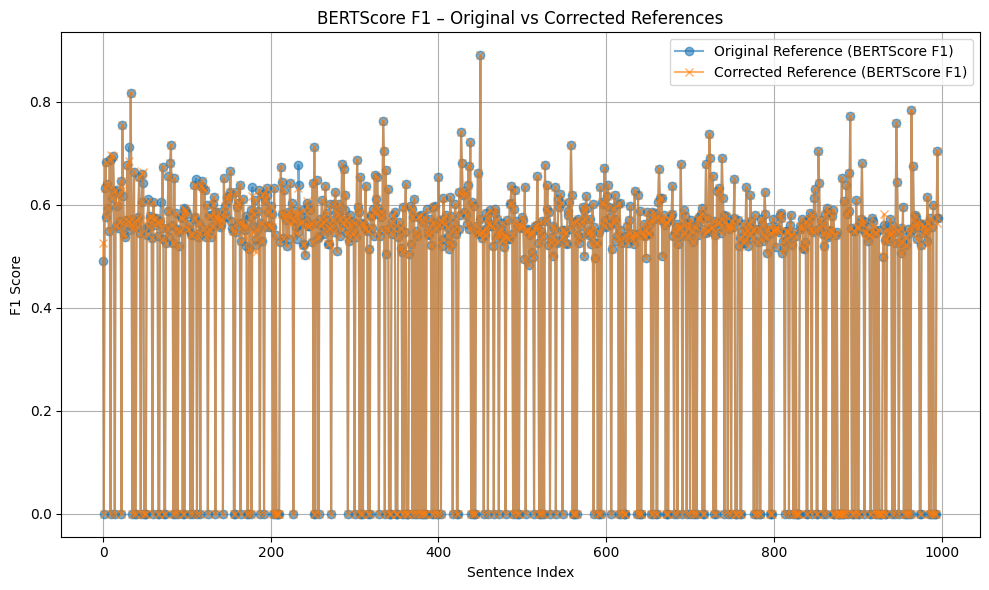


📊 Metric Comparison Summary:
BLEU Original   : 0.42
BLEU Corrected  : 0.42
chrF Original   : 8.33
chrF Corrected  : 8.32
BERTScore F1 (Original Avg)   : 0.4493
BERTScore F1 (Corrected Avg)  : 0.4491


In [1]:
#  Install dependencies
!pip install -q evaluate bert-score sacrebleu matplotlib transformers tqdm

# Imports
import os
import torch
import matplotlib.pyplot as plt
from tqdm import tqdm
from evaluate import load as load_metric
from bert_score import score as bert_score
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM

# Paths
base_path = "/content/flores-fix-4-africa/data"
corrected_file_path = f"{base_path}/corrected/dev/nso_Latn.dev"
original_file_path = f"{base_path}/original/dev/nso_Latn.dev"
english_src_path = f"{base_path}/original/dev/eng_Latn.dev"

#  Clone dataset repo if needed
if not os.path.exists(corrected_file_path):
    !git clone https://github.com/dsfsi/flores-fix-4-africa.git /content/flores-fix-4-africa

#  Load dataset
with open(corrected_file_path, "r", encoding="utf-8") as f:
    corrected_refs = [line.strip() for line in f if line.strip()]
with open(original_file_path, "r", encoding="utf-8") as f:
    original_refs = [line.strip() for line in f if line.strip()]
with open(english_src_path, "r", encoding="utf-8") as f:
    english_sample = [line.strip() for line in f if line.strip()]

#  Truncate all to shortest length
min_len = min(len(corrected_refs), len(original_refs), len(english_sample))
corrected_refs = corrected_refs[:min_len]
original_refs = original_refs[:min_len]
english_sample = english_sample[:min_len]

# Use GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#  Load model/tokenizer
nllb_model_id = "facebook/nllb-200-distilled-600M"
nllb_tokenizer = AutoTokenizer.from_pretrained(nllb_model_id)
nllb_model = AutoModelForSeq2SeqLM.from_pretrained(nllb_model_id).to(device)

#  Translate English to Sepedi
nllb_preds = []
batch_size = 8
forced_lang_token = nllb_tokenizer.convert_tokens_to_ids("__nso_Latn__")

for i in tqdm(range(0, len(english_sample), batch_size), desc="Translating (GPU)"):
    batch = english_sample[i:i + batch_size]
    inputs = nllb_tokenizer(batch, return_tensors="pt", padding=True, truncation=True, max_length=64)
    inputs = {k: v.to(device) for k, v in inputs.items()}
    inputs['forced_bos_token_id'] = forced_lang_token

    with torch.no_grad():
        outputs = nllb_model.generate(
            **inputs,
            max_length=48,
            num_beams=1,
        )
    decoded = nllb_tokenizer.batch_decode(outputs, skip_special_tokens=True)
    nllb_preds.extend(decoded)

# Evaluation: BLEU
bleu = load_metric("sacrebleu")
bleu_orig = bleu.compute(predictions=nllb_preds, references=[[r] for r in original_refs])
bleu_corr = bleu.compute(predictions=nllb_preds, references=[[r] for r in corrected_refs])

# Evaluation: chrF
chrf = load_metric("chrf")
chrf_orig = chrf.compute(predictions=nllb_preds, references=[[r] for r in original_refs])
chrf_corr = chrf.compute(predictions=nllb_preds, references=[[r] for r in corrected_refs])

# Evaluation: BERTScore (using GPU now)
_, _, f1_orig = bert_score(nllb_preds, original_refs, lang="nso", verbose=False, device=device)
_, _, f1_corr = bert_score(nllb_preds, corrected_refs, lang="nso", verbose=False, device=device)

# Visualization
plt.figure(figsize=(10, 6))
plt.plot(f1_orig.cpu().numpy(), label="Original Reference (BERTScore F1)", marker='o', alpha=0.6)
plt.plot(f1_corr.cpu().numpy(), label="Corrected Reference (BERTScore F1)", marker='x', alpha=0.6)
plt.title("BERTScore F1 – Original vs Corrected References")
plt.xlabel("Sentence Index")
plt.ylabel("F1 Score")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

#Metric Summary
print("\n📊 Metric Comparison Summary:")
print(f"BLEU Original   : {bleu_orig['score']:.2f}")
print(f"BLEU Corrected  : {bleu_corr['score']:.2f}")
print(f"chrF Original   : {chrf_orig['score']:.2f}")
print(f"chrF Corrected  : {chrf_corr['score']:.2f}")
print(f"BERTScore F1 (Original Avg)   : {f1_orig.mean().item():.4f}")
print(f"BERTScore F1 (Corrected Avg)  : {f1_corr.mean().item():.4f}")
